Sample of generated Polymarket data:
                   timestamp                         market   price  \
0 2026-01-03 23:22:28.407691  Will Trump win 2024 election?  0.4875   
1 2026-01-04 00:22:28.407691  Will Trump win 2024 election?  0.4850   
2 2026-01-04 01:22:28.407691  Will Trump win 2024 election?  0.4945   
3 2026-01-04 02:22:28.407691  Will Trump win 2024 election?  0.5166   
4 2026-01-04 03:22:28.407691  Will Trump win 2024 election?  0.5112   
5 2026-01-04 04:22:28.407691  Will Trump win 2024 election?  0.5062   
6 2026-01-04 05:22:28.407691  Will Trump win 2024 election?  0.5286   
7 2026-01-04 06:22:28.407691  Will Trump win 2024 election?  0.5376   
8 2026-01-04 07:22:28.407691  Will Trump win 2024 election?  0.5277   
9 2026-01-04 08:22:28.407691  Will Trump win 2024 election?  0.5335   

   volume_usd  
0          45  
1          41  
2          47  
3          57  
4          44  
5          44  
6          57  
7          47  
8          47  
9         167  

Tota

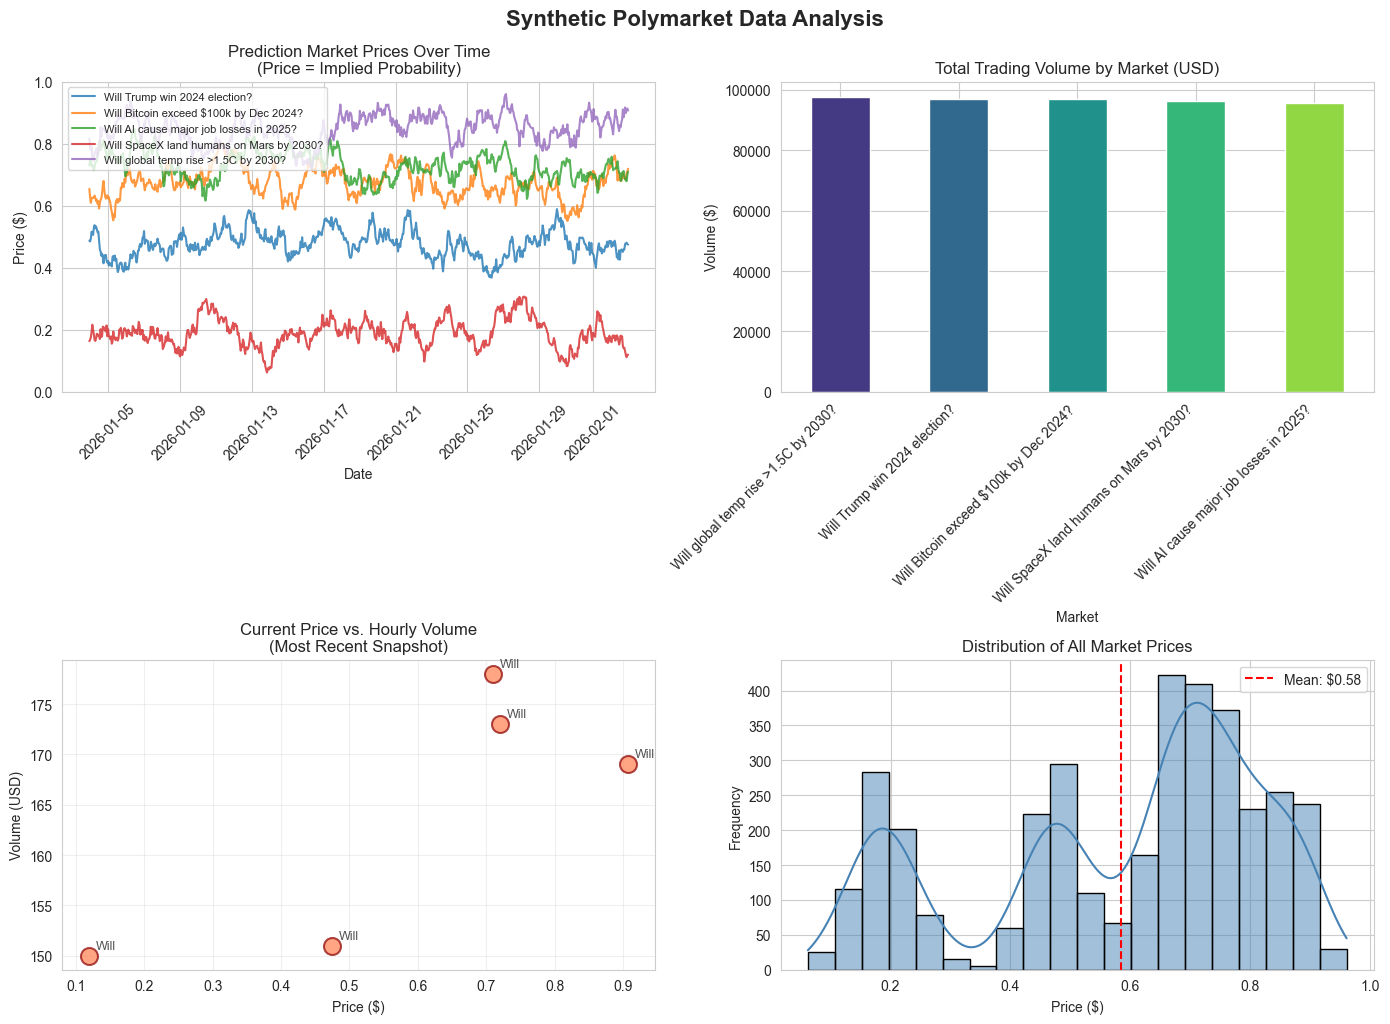


=== STATISTICAL SUMMARY ===
Average market price: $0.5837 (58.37% probability)
Price volatility (std dev): 0.2352
Total simulated volume: $483,956

Most volatile market (by price std dev):
market
Will Bitcoin exceed $100k by Dec 2024?    0.047396
Name: price, dtype: float64


In [5]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# Set random seed for reproducibility
np.random.seed(42)

# ============================================================================
# STEP 1: GENERATE FAKE POLYMARKET DATA
# ============================================================================
# Polymarket context: 
# - Markets represent binary events (e.g., "Will Candidate X win?")
# - Prices are quoted as $0.00-$1.00, interpreted as probability percentages
# - Typical markets have 100-1000+ trades per day during active periods

# Define 5 realistic prediction market events
markets = [
    "Will Trump win 2024 election?",
    "Will Bitcoin exceed $100k by Dec 2024?",
    "Will AI cause major job losses in 2025?",
    "Will SpaceX land humans on Mars by 2030?",
    "Will global temp rise >1.5C by 2030?"
]

# Generate timestamps: hourly data for last 30 days
start_date = datetime.now() - timedelta(days=30)
timestamps = [start_date + timedelta(hours=i) for i in range(30 * 24)]  # 720 hours

# Create empty list to store all records
data = []

# Generate synthetic market data for each event
for market in markets:
    # Starting probability varies by market (e.g., Bitcoin >50%, Mars landing <20%)
    base_prob = {
        markets[0]: 0.48,  # Trump election - competitive
        markets[1]: 0.65,  # Bitcoin - bullish sentiment
        markets[2]: 0.72,  # AI job losses - high concern
        markets[3]: 0.18,  # Mars landing - unlikely soon
        markets[4]: 0.85   # Climate change - high consensus
    }[market]
    
    # Simulate price movement with random walk + mean reversion
    current_price = base_prob
    for ts in timestamps:
        # Small random movement (±2%) with tendency to revert toward base probability
        movement = np.random.normal(0, 0.015) + 0.05 * (base_prob - current_price)
        current_price = np.clip(current_price + movement, 0.01, 0.99)  # Keep in valid range
        
        # Volume correlates with price volatility and time of day
        hour = ts.hour
        is_active_hours = 8 <= hour <= 22  # Higher activity during daytime
        base_volume = 150 if is_active_hours else 40
        volume = int(base_volume * (1 + abs(movement) * 20))  # More volume when price moves
        
        # Append record
        data.append({
            "timestamp": ts,
            "market": market,
            "price": round(current_price, 4),  # Price = implied probability
            "volume_usd": volume
        })

# Convert to DataFrame
df = pd.DataFrame(data)

# Display first few rows to verify structure
print("Sample of generated Polymarket data:")
print(df.head(10))
print(f"\nTotal records generated: {len(df)}")
print(f"Date range: {df['timestamp'].min()} to {df['timestamp'].max()}")

# ============================================================================
# STEP 2: BASIC VISUALIZATIONS
# ============================================================================
# Set seaborn style for better aesthetics
sns.set_style("whitegrid")
plt.figure(figsize=(14, 10))

# ----------------------------------------------------------------------------
# VISUALIZATION 1: Price (Probability) Time Series for All Markets
# ----------------------------------------------------------------------------
plt.subplot(2, 2, 1)
for market in markets:
    market_data = df[df["market"] == market]
    plt.plot(market_data["timestamp"], market_data["price"], label=market, alpha=0.8, linewidth=1.5)

plt.title("Prediction Market Prices Over Time\n(Price = Implied Probability)")
plt.xlabel("Date")
plt.ylabel("Price ($)")
plt.legend(loc="upper left", fontsize=8)
plt.xticks(rotation=45)
plt.ylim(0, 1)  # Prices always between $0 and $1
plt.tight_layout()

# COMMENTARY: 
# Prices near $1.00 mean the market believes the event is very likely (>90% probability).
# Prices near $0.00 mean the event is considered very unlikely (<10% probability).
# Volatility spikes often reflect news events (simulated here via random walk).

# ----------------------------------------------------------------------------
# VISUALIZATION 2: Volume Distribution by Market
# ----------------------------------------------------------------------------
plt.subplot(2, 2, 2)
volume_summary = df.groupby("market")["volume_usd"].sum().sort_values(ascending=False)
colors = sns.color_palette("viridis", len(volume_summary))
volume_summary.plot(kind="bar", color=colors, ax=plt.gca())
plt.title("Total Trading Volume by Market (USD)")
plt.xlabel("Market")
plt.ylabel("Volume ($)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

# COMMENTARY:
# Higher volume markets typically reflect more public interest or recent news.
# In real Polymarket data, election and crypto markets often dominate volume.

# ----------------------------------------------------------------------------
# VISUALIZATION 3: Price vs Volume Scatter Plot (Latest Snapshot)
# ----------------------------------------------------------------------------
plt.subplot(2, 2, 3)
# Get most recent price for each market
latest_data = df.sort_values("timestamp").groupby("market").last().reset_index()

plt.scatter(latest_data["price"], latest_data["volume_usd"], 
            s=150, alpha=0.7, color="coral", edgecolors="darkred", linewidth=1.5)

# Annotate each point with market name (abbreviated)
for idx, row in latest_data.iterrows():
    plt.annotate(row["market"].split(" ")[0],  # Just first word for readability
                 (row["price"], row["volume_usd"]),
                 xytext=(5, 5), textcoords="offset points",
                 fontsize=9, alpha=0.8)

plt.title("Current Price vs. Hourly Volume\n(Most Recent Snapshot)")
plt.xlabel("Price ($)")
plt.ylabel("Volume (USD)")
plt.grid(True, alpha=0.3)
plt.tight_layout()

# COMMENTARY:
# No strong correlation expected between price level and volume.
# High volume at extreme prices (<0.10 or >0.90) often indicates "closing positions"
# as outcomes become certain.

# ----------------------------------------------------------------------------
# VISUALIZATION 4: Price Distribution Histogram
# ----------------------------------------------------------------------------
plt.subplot(2, 2, 4)
sns.histplot(df["price"], bins=20, kde=True, color="steelblue", edgecolor="black")
plt.title("Distribution of All Market Prices")
plt.xlabel("Price ($)")
plt.ylabel("Frequency")
plt.axvline(df["price"].mean(), color="red", linestyle="--", 
            label=f"Mean: ${df['price'].mean():.2f}")
plt.legend()
plt.tight_layout()

# COMMENTARY:
# A bimodal distribution (peaks near 0 and 1) would indicate markets are 
# resolving toward certainty. Our synthetic data shows moderate uncertainty
# (peak near 0.5-0.7) reflecting active, unresolved events.

# ============================================================================
# STEP 3: DISPLAY ALL PLOTS
# ============================================================================
plt.suptitle("Synthetic Polymarket Data Analysis", fontsize=16, fontweight="bold", y=1.02)
plt.show()

# ============================================================================
# STEP 4: QUICK STATISTICAL SUMMARY
# ============================================================================
print("\n=== STATISTICAL SUMMARY ===")
print(f"Average market price: ${df['price'].mean():.4f} ({df['price'].mean()*100:.2f}% probability)")
print(f"Price volatility (std dev): {df['price'].std():.4f}")
print(f"Total simulated volume: ${df['volume_usd'].sum():,}")
print(f"\nMost volatile market (by price std dev):")
volatility = df.groupby("market")["price"].std().sort_values(ascending=False)
print(volatility.head(1))